In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib
import sys
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
# from preprocessing import clean

In [2]:
df = pd.read_csv('data.csv')

In [3]:
def clean(data):
  clean = data.copy()
  target = data.columns[data.isna().any()].tolist()
  for t in target:
    index = clean[clean[t].isna()].index
    for idx in index:
      clean.loc[idx, t] = clean.loc[0:idx, t].mean()

  return clean

# Data Preprocessing

In [4]:
split_time = int(0.8*len(df))
clean_df = clean(df)

In [5]:
train = clean_df.iloc[:split_time]
test = clean_df.iloc[split_time:]

# Design LSTM

In [6]:
#Create windowed data for LSTM
def create_windowed_dataset(data, window_size, predshift, valcol, shuffle=1):
    data_X = []
    data_Y = []
    for i in range(len(data) - window_size - predshift):
      window = []
      for col in valcol:
        series = data[col]
        window.append(np.array(series[i:i+window_size]))
      window = np.array(window).reshape(len(valcol)*window_size)
      data_X.append(window)
      data_Y.append(np.array(data[valcol[0]])[i+window_size+predshift-1])
    data_X = np.array(data_X)
    data_Y = np.array(data_Y)

    indices = np.arange(len(data_X))
    if shuffle:
      np.random.shuffle(indices)
    data_X = data_X[indices]
    data_Y = data_Y[indices]

    return data_X, data_Y.reshape(-1, 1)

#Design and Run LSTM model
def run_model(train, window_size, predshift, batch_size, valcol):
    train_x, train_y = create_windowed_dataset(train, window_size, predshift, valcol, shuffle=1)
    trainset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    trainset = trainset.batch(batch_size).prefetch(1)
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size*len(valcol), 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
    model.compile(loss = tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(trainset, epochs=50, verbose=0)
    return model

#Test LSTM model
def test_model(origdata, test, model, window_size, predshift, valcol):
    [test_x, test_y] = create_windowed_dataset(test, window_size, predshift, valcol, shuffle=0)
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1],1))
    test_predictions = model.predict(test_x)

    rmse = sqrt(mean_squared_error(test_y, test_predictions))
    mae = mean_absolute_error(test_y, test_predictions)
    return rmse, mae, test_predictions

# Overview of forecasts (a={1,4,24}, w={2,8,24})

In [7]:
window_size = [2, 8, 24]
predshift = [1, 4, 24]
batch_size = 32

## Modeled Data

In [8]:
m_RMSE = np.zeros((len(window_size), len(predshift)))
m_MAE = np.zeros((len(window_size), len(predshift)))
m_true_predictions = [[None for _ in range(len(window_size))] for _ in range(len(predshift))]
valcol = ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC']

In [9]:
for i, psh in enumerate(predshift):
  for j, w in enumerate(window_size):
    model = run_model(train, w, psh, batch_size, valcol)
    m_RMSE[i][j], m_MAE[i][j], m_true_predictions[i][j] = test_model(clean_df, test, model, w, psh, valcol)

54/54 [==============================] - 1s 5ms/step


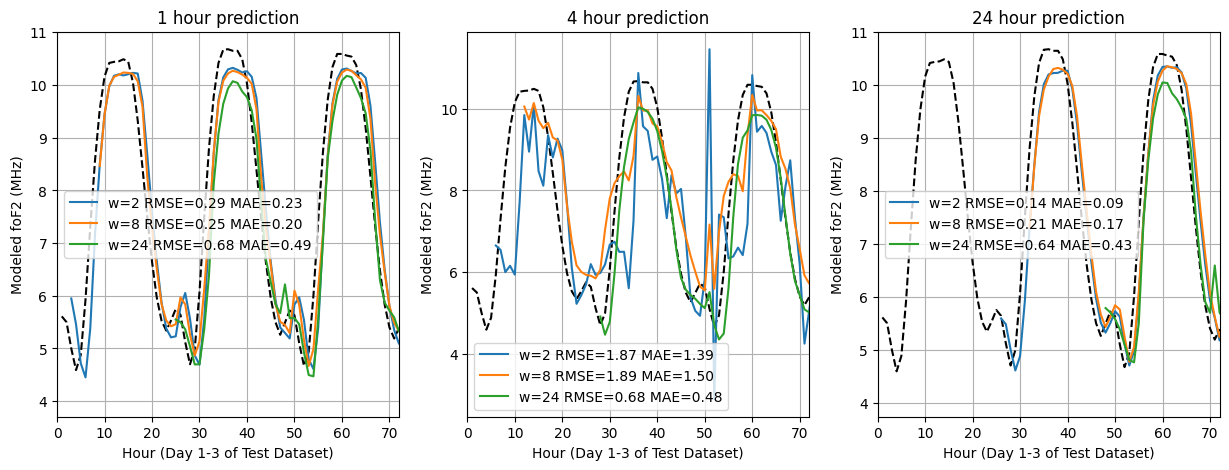

In [10]:
fig, ax = plt.subplots(1, len(predshift), figsize=(15, 5))
t_index_plot = np.arange(1,test.shape[0],1)[0:72]
truth = np.array(test['foF2m'])
for i, psh in enumerate(predshift):
    ax[i].plot(t_index_plot, truth[t_index_plot], 'k--')
    for j, w in enumerate(window_size):
        idx = np.arange(w+psh, truth.shape[0],1)[0:72]
        ax[i].plot(idx, m_true_predictions[i][j][0:72], label=f'w={w} RMSE={m_RMSE[i][j]:.2f} MAE={m_MAE[i][j]:.2f}')
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xlim(0,24*3)
        ax[i].set_xlabel('Hour (Day 1-3 of Test Dataset)')
        ax[i].set_ylabel('Modeled foF2 (MHz)')
        ax[i].set_title(f'{psh} hour prediction')
plt.show()

## Observed Data

In [11]:
o_RMSE = np.zeros((len(window_size), len(predshift)))
o_MAE = np.zeros((len(window_size), len(predshift)))
o_true_predictions = [[None for _ in range(len(window_size))] for _ in range(len(predshift))]
valcol = ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC']

In [12]:
for i, psh in enumerate(predshift):
  for j, w in enumerate(window_size):
    model = run_model(train, w, psh, batch_size, valcol)
    o_RMSE[i][j], o_MAE[i][j], o_true_predictions[i][j] = test_model(clean_df, test, model, w, psh, valcol)

54/54 [==============================] - 1s 5ms/step


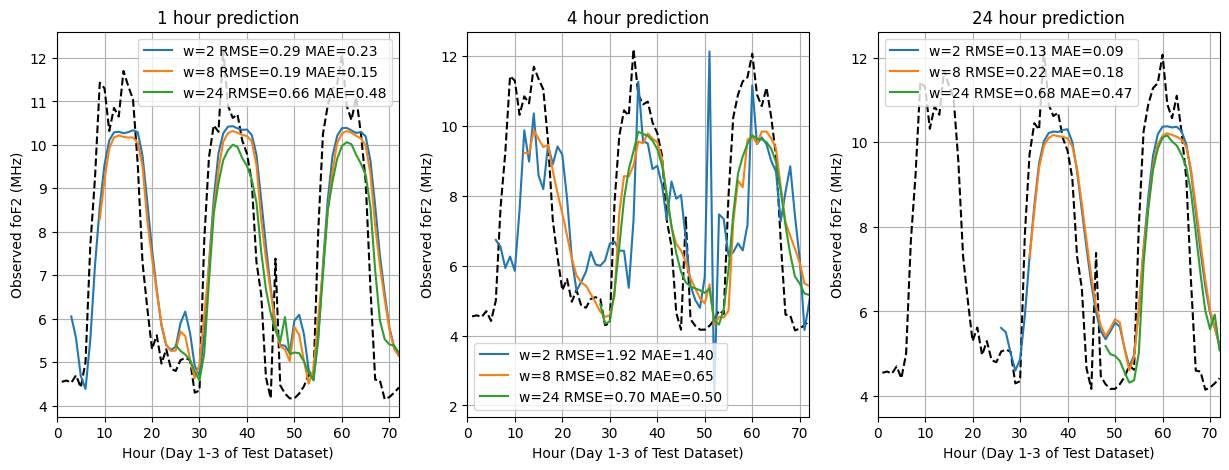

In [13]:
fig, ax = plt.subplots(1, len(predshift), figsize=(15, 5))
t_index_plot = np.arange(1,test.shape[0],1)[0:72]
truth = np.array(test['foF2o'])
for i, psh in enumerate(predshift):
    ax[i].plot(t_index_plot, truth[t_index_plot], 'k--')
    for j, w in enumerate(window_size):
        idx = np.arange(w+psh, truth.shape[0],1)[0:72]
        ax[i].plot(idx, o_true_predictions[i][j][0:72], label=f'w={w} RMSE={o_RMSE[i][j]:.2f} MAE={o_MAE[i][j]:.2f}')
        ax[i].legend()
        ax[i].grid()
        ax[i].set_xlim(0,24*3)
        ax[i].set_xlabel('Hour (Day 1-3 of Test Dataset)')
        ax[i].set_ylabel('Observed foF2 (MHz)')
        ax[i].set_title(f'{psh} hour prediction')
plt.show()

# Window size VS forecasting # hours ahead

In [14]:
window_size = [3, 8, 13, 18, 23]
predshift = [1, 7, 13, 19, 25]
RMSE_m = np.zeros((len(window_size),len(window_size))) * np.nan
RMSE_o = np.zeros((len(window_size),len(window_size))) * np.nan
for ai,a in enumerate(predshift):
  for wi,w in enumerate(window_size):
    model_m = run_model(train, w, a, batch_size, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])
    RMSE_m[ai][wi] = test_model(clean_df, test, model_m, w, a, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])[0]
    model_o = run_model(train, w, a, batch_size, ['foF2o', 'SSN', 'Kp', 'Dst', 'TEC'])
    RMSE_o[ai][wi] = test_model(clean_df, test, model_o, w, a, ['foF2o', 'SSN', 'Kp', 'Dst', 'TEC'])[0]


54/54 [==============================] - 1s 5ms/step


<ipython-input-15-682451b507fb>:5: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cax = ax.contourf(RMSE_m, cmap='magma', interpolation='nearest')
<ipython-input-15-682451b507fb>:13: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cax2 = ax2.contourf(RMSE_o, cmap='magma', interpolation='nearest')


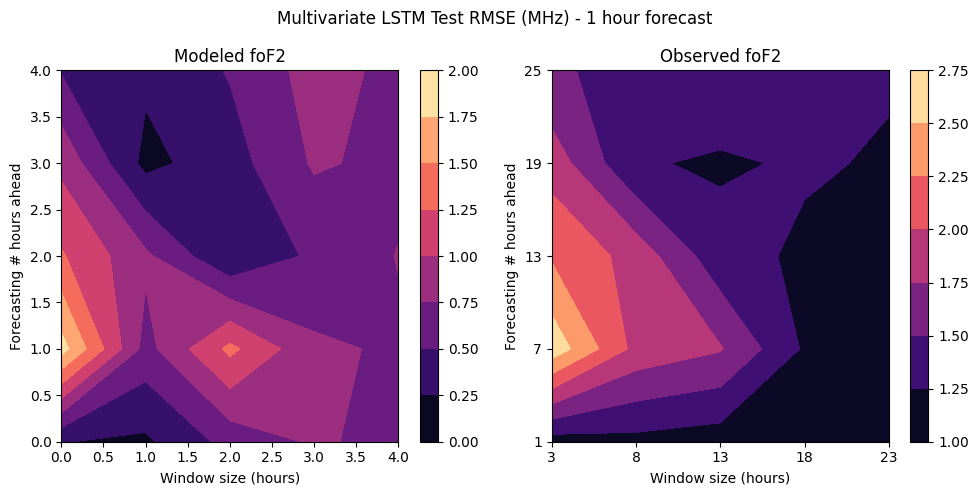

In [15]:
window_size = [3, 8, 13, 18, 23]
predshift = [1, 7, 13, 19, 25]
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma', interpolation='nearest')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Forecasting # hours ahead')
# ax.set_xticks(np.arange(RMSE_m.shape[1]), np.array(window_size))
# ax.set_yticks(np.arange(RMSE_m.shape[0]), np.array(predshift))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma', interpolation='nearest')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Forecasting # hours ahead')
ax2.set_xticks(np.arange(RMSE_o.shape[1]), np.array(window_size))
ax2.set_yticks(np.arange(RMSE_o.shape[0]), np.array(predshift))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)
fig.suptitle('Multivariate LSTM Test RMSE (MHz) - 1 hour forecast')
plt.tight_layout()

# Window size VS hour of forecast

In [16]:
window_size = [3, 8, 13, 18, 23]
day_hour = [3, 8, 13, 18, 23]
RMSE_m = np.zeros((len(day_hour),len(window_size))) * np.nan
RMSE_o = np.zeros((len(day_hour),len(window_size))) * np.nan
for wi,w in enumerate(window_size):
  model_m = run_model(train, w, 24, batch_size, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])
  pred_m = test_model(clean_df, test, model_m, w, 24, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])[2]
  RMSE_m[:,wi] = [sqrt(mean_squared_error(np.array(test['foF2m'])[24+w+h::24], pred_m[h::24])) for h in day_hour]
  model_o = run_model(train, w, 24, batch_size, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])
  pred_o = test_model(clean_df, test, model_o, w, 24, ['foF2o', 'SSN', 'Kp', 'Dst', 'TEC'])[2]
  RMSE_o[:,wi] = [sqrt(mean_squared_error(np.array(test['foF2o'])[24+w+h::24], pred_o[h::24])) for h in day_hour]

54/54 [==============================] - 1s 5ms/step


<ipython-input-17-83418c88840e>:3: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cax = ax.contourf(RMSE_m, cmap='magma', interpolation='nearest')
<ipython-input-17-83418c88840e>:11: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cax2 = ax2.contourf(RMSE_o, cmap='magma', interpolation='nearest')


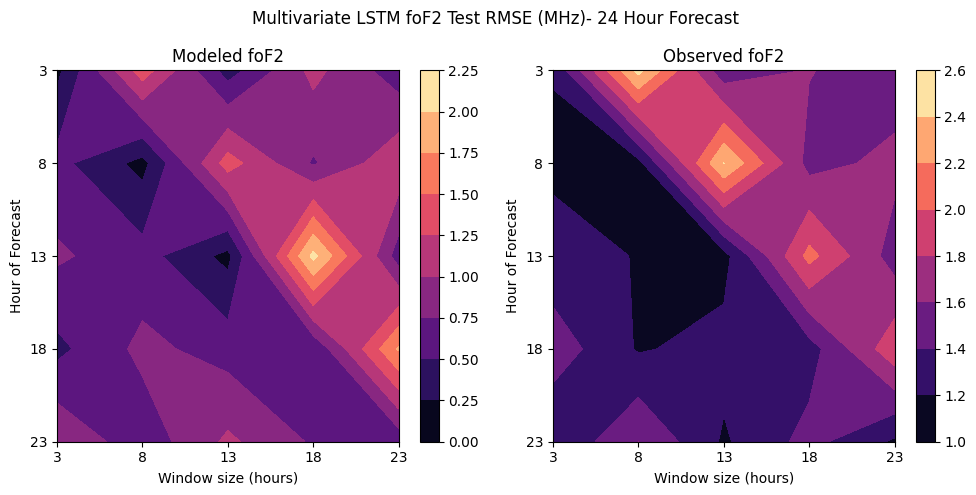

In [17]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma', interpolation='nearest')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Hour of Forecast')
ax.set_xticks(np.arange(RMSE_m.shape[1]), np.array(window_size))
ax.set_yticks(np.arange(RMSE_m.shape[0]), np.array(day_hour)[::-1])
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma', interpolation='nearest')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Hour of Forecast')
ax2.set_xticks(np.arange(RMSE_o.shape[1]), np.array(window_size))
ax2.set_yticks(np.arange(RMSE_o.shape[0]), np.array(day_hour)[::-1])
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

plt.suptitle('Multivariate LSTM foF2 Test RMSE (MHz)- 24 Hour Forecast')
plt.tight_layout()

# Window size VS hour of forecast (daily windowing)

In [18]:
window_size = [2, 10, 18, 26, 34]
day_hour = [3, 8, 13, 18, 23]
RMSE_m = np.zeros((len(day_hour),len(window_size))) * np.nan
RMSE_o = np.zeros((len(day_hour),len(window_size))) * np.nan

for hi, h in enumerate(day_hour):
  for wi,w in enumerate(window_size):
    model_m = run_model(train[h::24], w, 1, batch_size, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])
    pred_m = test_model(clean_df, test[h::24], model_m, w, 1, ['foF2m', 'SSN', 'Kp', 'Dst', 'TEC'])[2]
    true_m = test.loc[h::24, 'foF2m']
    RMSE_m[hi,wi] = sqrt(mean_squared_error(np.array(true_m)[w+1:], pred_m))
    model_o = run_model(train[h::24], w, 1, batch_size, ['foF2o', 'SSN', 'Kp', 'Dst', 'TEC'])
    pred_o = test_model(clean_df, test[h::24], model_o, w, 1, ['foF2o', 'SSN', 'Kp', 'Dst', 'TEC'])[2]
    true_o = test.loc[h::24, 'foF2o']
    RMSE_o[hi,wi] = sqrt(mean_squared_error(np.array(true_o)[w+1:], pred_o))

np.savetxt('modeled3.txt', RMSE_m, fmt='%.2f')
np.savetxt('observed3.txt', RMSE_o, fmt='%.2f')

2/2 [==============================] - 1s 7ms/step


2/2 [==============================] - 1s 8ms/step


2/2 [==============================] - 1s 10ms/step


<ipython-input-19-294a30c41798>:3: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cax = ax.contourf(RMSE_m, cmap='magma', interpolation='nearest')
<ipython-input-19-294a30c41798>:11: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cax2 = ax2.contourf(RMSE_o, cmap='magma', interpolation='nearest')


Text(0.5, 0.98, 'Multivariate LSTM foF2 Test RMSE (MHz)- 1 Day Forecast')

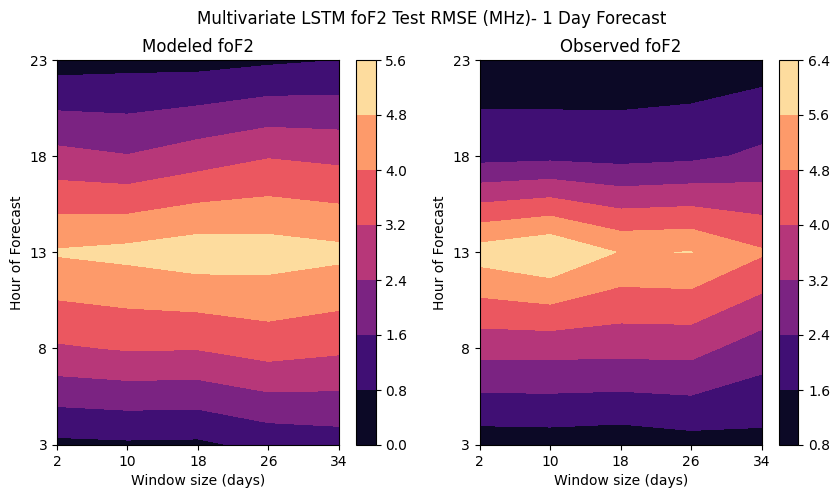

In [19]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma', interpolation='nearest')
ax.set_xlabel('Window size (days)')
ax.set_ylabel('Hour of Forecast')
ax.set_xticks(np.arange(RMSE_m.shape[1]), np.array(window_size))
ax.set_yticks(np.arange(RMSE_m.shape[0]), np.array(day_hour))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma', interpolation='nearest')
ax2.set_xlabel('Window size (days)')
ax2.set_ylabel('Hour of Forecast')
ax2.set_xticks(np.arange(RMSE_o.shape[1]), np.array(window_size))
ax2.set_yticks(np.arange(RMSE_o.shape[0]), np.array(day_hour))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

plt.suptitle('Multivariate LSTM foF2 Test RMSE (MHz)- 1 Day Forecast')